In [3]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import os

Lets load some images.

In [4]:
def load_data(path, grid_size=128):
    # get all files in path
    files = os.listdir(path)
    # sort files
    files.sort()
    print(files)
    # read binary files
    data = []
    for file in files:
        with open(os.path.join(path, file), 'rb') as f:
            grid = jnp.frombuffer(f.read(), dtype=jnp.float32)
            grid = grid.reshape(grid_size, grid_size, grid_size, 1)
            data.append(grid)
        
    return jnp.array(data)

grid_sequence = load_data('data/grid/01')


print(grid_sequence.shape)

['example.00005.0', 'example.00010.0', 'example.00015.0', 'example.00020.0', 'example.00025.0', 'example.00030.0', 'example.00035.0', 'example.00040.0', 'example.00045.0', 'example.00050.0', 'example.00055.0', 'example.00060.0', 'example.00065.0', 'example.00070.0', 'example.00075.0', 'example.00080.0', 'example.00085.0', 'example.00090.0']
(18, 128, 128, 128, 1)


In [5]:
def preprocess(data, grid_size=64):
    # resize data
    data = jnp.array([jax.image.resize(data[i], (grid_size, grid_size, grid_size, 1), method='tricubic') for i in range(data.shape[0])])

    return data

grid_sequence_res = preprocess(grid_sequence, 32)

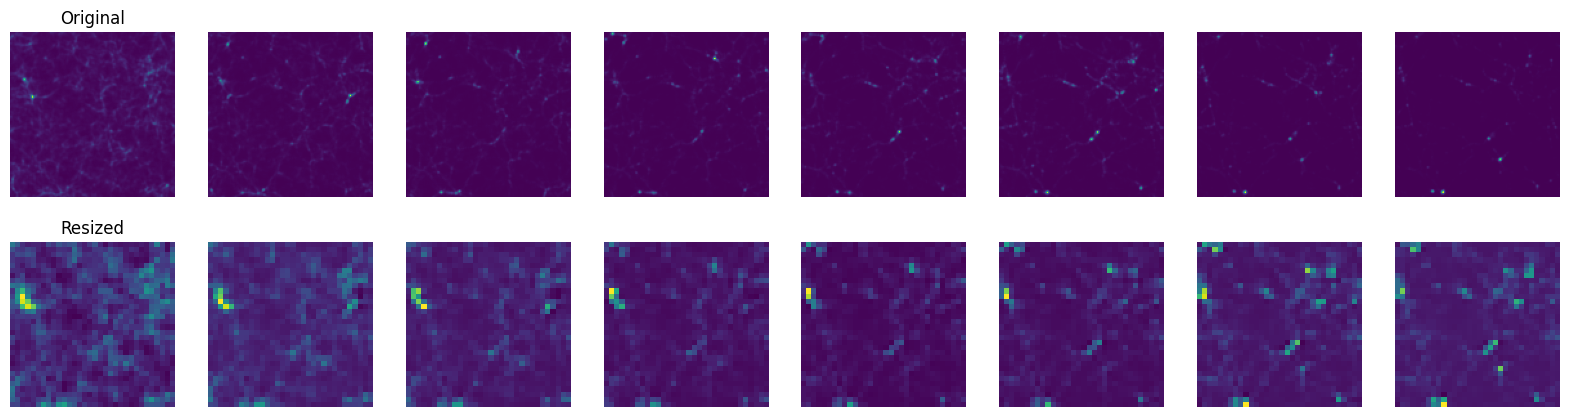

In [6]:
# plot a few slices
fig, ax = plt.subplots(2, 8, figsize=(20, 5))
# plot with normalized colormap
for i in range(8):
    ax[0, i].imshow(grid_sequence[i, :, :, grid_sequence.shape[-1] //2], cmap='viridis')
    ax[1, i].imshow(grid_sequence_res[i, :, :, grid_sequence_res.shape[-1]//2], cmap='viridis')
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    # set titles
    if i == 0:
        ax[0, i].set_title('Original')
        ax[1, i].set_title('Resized')

In [7]:
from flax import linen as nn
import optax

In [74]:
class UNet(nn.Module):
    def setup(self):
        self.encoder_blocks = [
            nn.Conv(features=4, kernel_size=(3, 3, 3), strides=(2, 2, 2)),
            nn.Conv(features=8, kernel_size=(3, 3, 3), strides=(2, 2, 2)),
            nn.Conv(features=16, kernel_size=(3, 3, 3), strides=(2, 2, 2)),
            nn.Conv(features=32, kernel_size=(3, 3, 3), strides=(2, 2, 2)),
        ]
        self.decoder_blocks = [
            nn.ConvTranspose(features=16, kernel_size=(3, 3, 3), strides=(2, 2, 2)),
            nn.ConvTranspose(features=16, kernel_size=(3, 3, 3), strides=(2, 2, 2)),
            nn.ConvTranspose(features=8, kernel_size=(3, 3, 3), strides=(2, 2, 2)),
            nn.ConvTranspose(features=4, kernel_size=(3, 3, 3), strides=(2, 2, 2)),
            nn.ConvTranspose(features=1, kernel_size=(3, 3, 3), strides=(2, 2, 2)),
        ]

    def __call__(self, x):
        skips = []
        skips.append(x)
        for index, block in enumerate(self.encoder_blocks):
            skips.append(x)
            print("before", x.shape)
            x = block(x)
            print("after", x.shape)
        
        skips.append(0)

        skips = skips[::-1]

        print("skips", len(skips))
        
        for index, (skip, block) in enumerate(zip(skips, self.decoder_blocks)):
            if index > 0:
                x = jnp.concatenate([x, skip], axis=-1)
            print("before", x.shape)
            x = block(x)
            print("after", x.shape)
        return x


In [75]:
init_rng = jax.random.key(0)

unet = UNet()
network_params = unet.init(init_rng, grid_sequence_res[0])

# test prediction
x = jax.random.normal(init_rng, (1, 32, 32, 32, 1))
y = unet.apply(network_params, x)
# print(y.shape)

# print number of parameters
print('Number of parameters:', sum(p.size for p in jax.tree.flatten(network_params)[0]))

before (32, 32, 32, 1)
after (16, 16, 16, 4)
before (16, 16, 16, 4)


In [27]:
from flax import struct

@struct.dataclass
class Batch:
    start : jnp.ndarray
    target : jnp.ndarray

batches = [Batch(grid_sequence_res[0:-2], grid_sequence_res[1:-1])]



In [28]:
from functools import partial

def reconstruction_loss(network_params : optax.Params,  network : nn.Module, batch : Batch):
  # print(images.shape)
  prediction = network.apply(network_params, batch.start)
  print(prediction.shape)
  print(batch.target.shape)
  # print(prediction.shape, images.shape)
  loss = jnp.mean(jnp.sum(jnp.square(prediction - batch.target), axis=(-1)))
  return loss

# @partial(jax.jit, static_argnums=(1,2))
def train_step(
  batch : Batch,
  network : nn.Module,
  optimizer : optax.GradientTransformation,
  optimizer_state : optax.OptState,
  network_params : optax.Params):

  grad_fn = jax.value_and_grad(reconstruction_loss, argnums=0)
  loss, grads = grad_fn(network_params, network, batch)

  updates, new_opt_state = optimizer.update(grads, optimizer_state)

  new_network_params = optax.apply_updates(network_params, updates)

  return loss, new_network_params, new_opt_state


In [29]:
learning_rate = 0.003

optimizer = optax.adam(learning_rate)
optimizer_state = optimizer.init(network_params)

num_epochs = 1

for epoch in range(num_epochs):

    loss_sum = 0
    for i in range(len(batches)):
        loss, network_params, optimizer_state =\
            train_step(batches[i], autoencoder, optimizer, optimizer_state, network_params)
        
        loss_sum += loss

    loss = loss_sum / len(batches)
        
    print(f"Epoch {epoch}, Loss: {loss}")

(16, 16, 16, 16, 4)
(16, 32, 32, 32, 1)


TypeError: sub got incompatible shapes for broadcasting: (16, 16, 16, 16, 4), (16, 32, 32, 32, 1).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.057508983..1.0169439].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.028339721..1.036851].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11501227..1.1578596].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008421053..1.0748769].


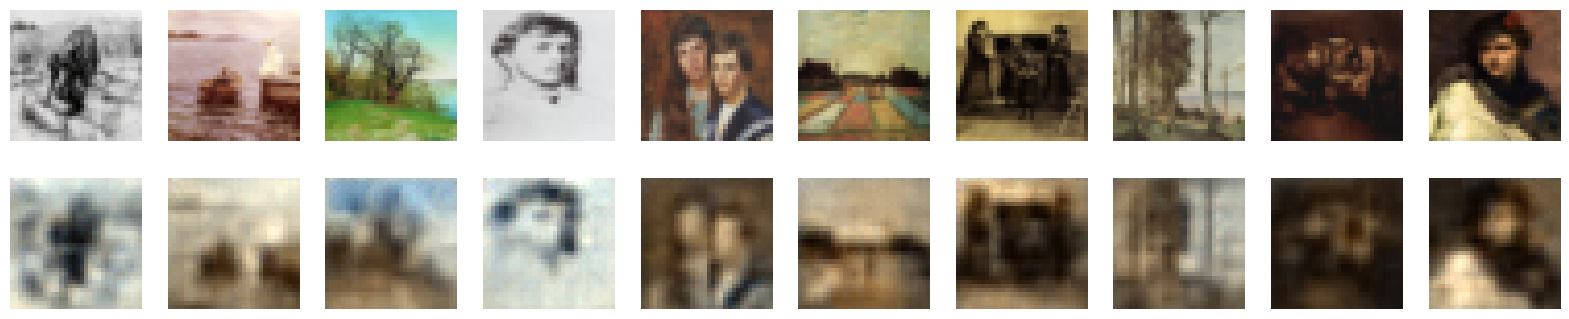

In [91]:
# plot a few reconstructions and the original images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    axs[0, i].imshow(batches[1][i])
    axs[0, i].axis("off")
    axs[1, i].imshow(autoencoder.apply(network_params, batches[1][i][None])[0])
    axs[1, i].axis("off")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3455393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5550222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3730304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4017879].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7117834].


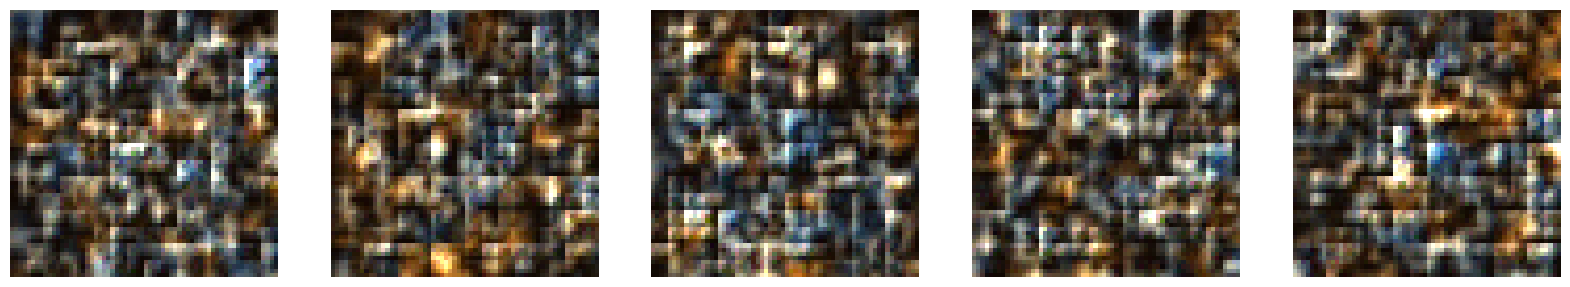

In [92]:
# generate new images from the latent space

encoder = Decoder(n_channels=3)
params = {'params':network_params['params']['decoder']}

keys = jax.random.split(init_rng, 5)
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    latent = jax.random.normal(keys[i], (1, 8, 8, 3*8))
    image = encoder.apply(params, latent)
    axs[i].imshow(image[0])
    axs[i].axis("off")
